# Active Subspaces

Sometimes, the behavior of an $N$-dimensional model $f$ can be explained best by a *linear reparameterization* of its inputs variables, i.e. we can write $f(\mathbf{x}) = g(\mathbf{y}) = g(\mathbf{M} \cdot \mathbf{x})$ where $\mathbf{M}$ has size $M \times N$ and $M < N$. When this happens, we say that $f$ admits an $M$-dimensional *active subspace* with basis given by $\mathbf{M}$'s rows. Those basis vectors are the main directions of variance of the function $f$.

The main directions are the eigenvectors of the matrix

$\mathbb{E}[\nabla f^T \cdot \nabla f] = \begin{pmatrix}
\mathbb{E}[f_{x_1} \cdot f_{x_1}] & \dots & \mathbb{E}[f_{x_1} \cdot f_{x_N}] \\
\dots & \dots & \dots \\
\mathbb{E}[f_{x_N} \cdot f_{x_1}] & \dots & \mathbb{E}[f_{x_N} \cdot f_{x_N}]
\end{pmatrix}$

whereas the eigenvalues reveal the subspace's dimensionality --that is, a large gap between the $M$-th and $(M+1)$-th eigenvalue indicates that an $M$-dimensional active subspace is present.

The necessary expected values are easy to compute from a tensor decomposition: they are just dot products between tensors. We will show a small demonstration of that in this notebook using a 4D function.

Reference: see e.g. ["Discovering an Active Subspace in a Single-Diode Solar Cell Model", P. Constantine et al. (2015)](https://arxiv.org/abs/1406.7607).

In [1]:
import tntorch as tn
import torch

def f(X):
    return X[:, 0] * X[:, 1] + X[:, 2]

ticks = 64
P = 100
N = 4

X = torch.rand((P, N))
X *= (ticks-1)
X = torch.round(X)
y = f(X)

We will fit this function `f` using a low-degree expansion in terms of [Legendre polynomials](https://github.com/rballester/tntorch/blob/master/tutorials/pce.ipynb).

In [2]:
t = tn.rand(shape=[ticks]*N, ranks_tt=2, ranks_tucker=2, requires_grad=True)
t.set_factors('legendre')

def loss(t):
    return torch.norm(t[X].torch()-y) / torch.norm(y)
tn.optimize(t, loss)


iter: 0      | loss:   0.999513 | total time:    0.0020
iter: 500    | loss:   0.977497 | total time:    0.8296
iter: 1000   | loss:   0.763221 | total time:    1.6445
iter: 1500   | loss:   0.044802 | total time:    2.5523
iter: 2000   | loss:   0.008546 | total time:    3.4807
iter: 2266   | loss:   0.008208 | total time:    3.9928 <- converged (tol=0.0001)


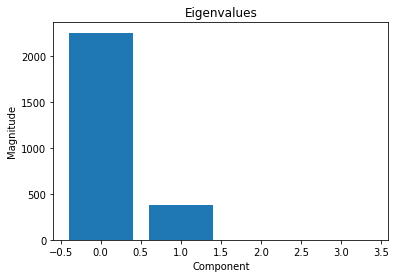

In [3]:
eigvals, eigvecs = tn.active_subspace(t)

import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.bar(range(N), eigvals.detach().numpy())
plt.title('Eigenvalues')
plt.xlabel('Component')
plt.ylabel('Magnitude')
plt.show()

In view of those eigenvalues, we can conclude that the learned model can be written (almost) perfectly in terms of 2 linearly reparameterized variables.